In [1]:
import os
import sys

# add path to sys
SRC_DIR = os.path.dirname(os.path.abspath('../../src'))
sys.path.append(SRC_DIR)

# import modules
import torch
import glob
from src import parse_args, Trainer
from src.models import *
from src.utils import *

In [2]:
# data path
pc_filename = '/media/shubham/GoldMine/datasets/KITTI/raw/2011_09_26/2011_09_26_drive_0009_sync/velodyne_points/data/0000000100.bin'
img_filename = '/media/shubham/GoldMine/datasets/KITTI/raw/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000100.png'
img_right_filename = '/media/shubham/GoldMine/datasets/KITTI/raw/2011_09_26/2011_09_26_drive_0009_sync/image_03/data/0000000100.png'

## Load Model

In [3]:
exp_str = 'vr3d.learning_rate_0.0001.n_xgrids_16.n_ygrids_16.xlim_0.0_70.0.ylim_-25.0_25.0.zlim_-2.5_1.0.max_depth_100.0.vol_size_256x256x16.img_size_512x256.dense_depth_True.concat_latent_vector_True.exp_id_kitti'

# define model
obj_label_len = len(pose_fields) + len(label_map) # 9 for poses, rest for object classes
model = VR3Dense(in_channels=1, n_xgrids=16, n_ygrids=16, obj_label_len=obj_label_len).to('cuda')

# load weights
model = load_pretrained_weights(model, '../../models', exp_str)

# define trainer
trainer = Trainer(dataroot=None, model=model, dataset=None, dense_depth=True,
                   n_xgrids=16, n_ygrids=16, epochs=None, batch_size=None, learning_rate=None, exp_str=exp_str,
                   xmin=0., xmax=70., ymin=-25., ymax=25., zmin=-2.5, zmax=1., max_depth=100., vol_size_x=256, 
                   vol_size_y=256, vol_size_z=16, img_size_x=512, img_size_y=256, loss_weights=None, mode='test')

Loaded pre-trained weights: ../../models/vr3d.learning_rate_0.0001.n_xgrids_16.n_ygrids_16.xlim_0.0_70.0.ylim_-25.0_25.0.zlim_-2.5_1.0.max_depth_100.0.vol_size_256x256x16.img_size_512x256.dense_depth_True.concat_latent_vector_True.exp_id_kitti/checkpoint_best.pt


## Read Files

In [4]:
# read point-cloud
velo_pc = read_velo_bin(pc_filename)
# read image
img_rgb = cv2.cvtColor(cv2.imread(img_filename), cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(cv2.imread(img_right_filename), cv2.COLOR_BGR2RGB)

## Perform Prediction

In [5]:
# perform prediction
(label_dict, dense_depth), dt = trainer.predict(velo_pc, img_rgb)
print('Inference took {} milliseconds'.format(dt))

Inference took 23.361 milliseconds


## Display Prediction

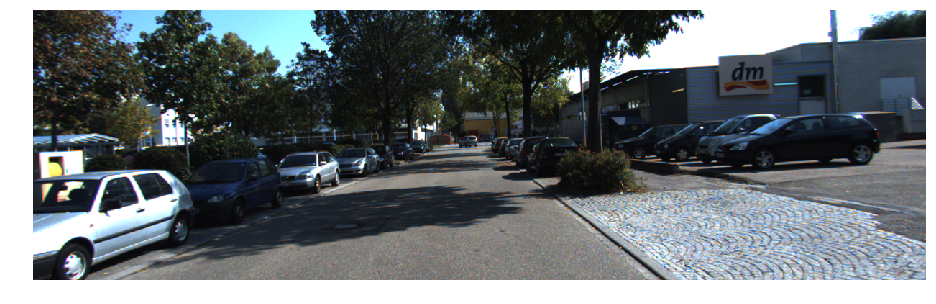

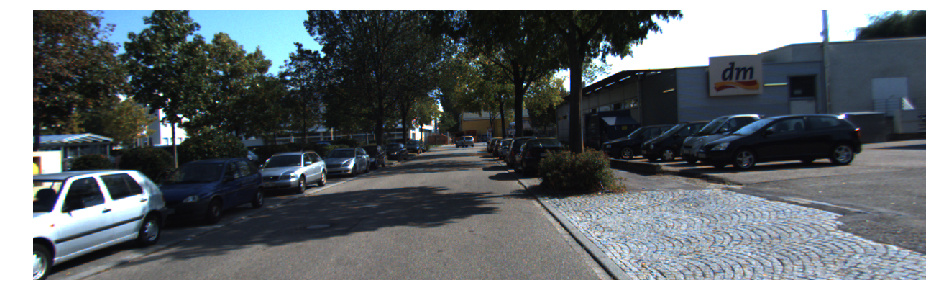

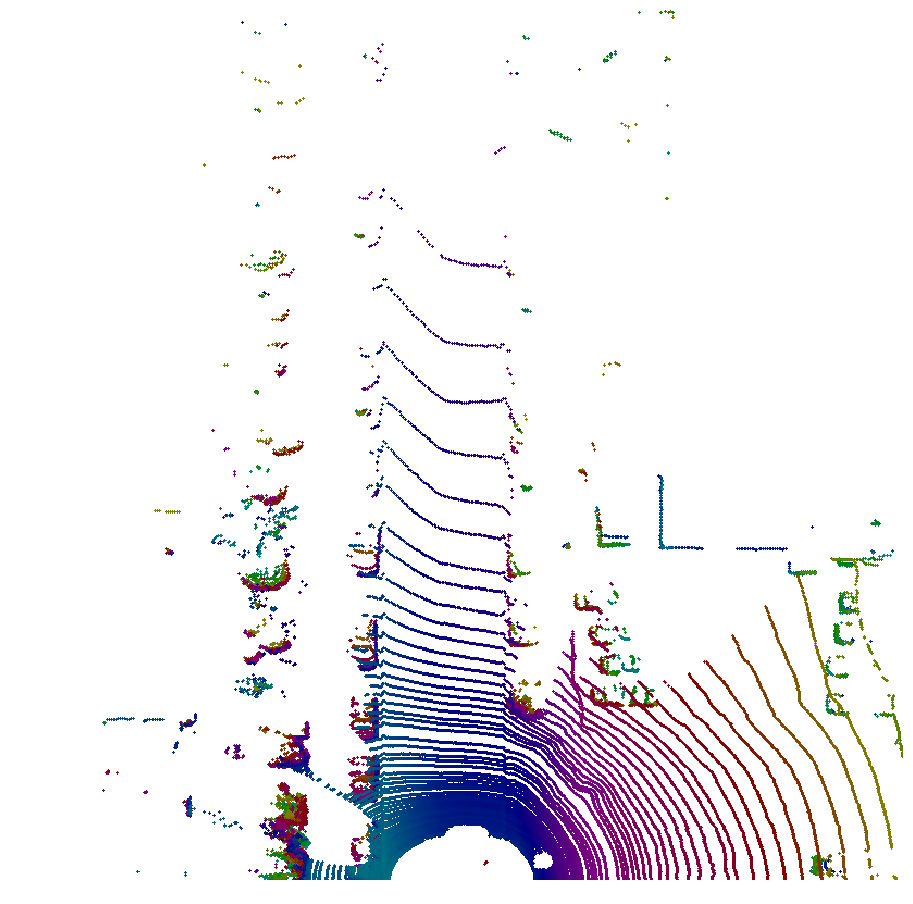

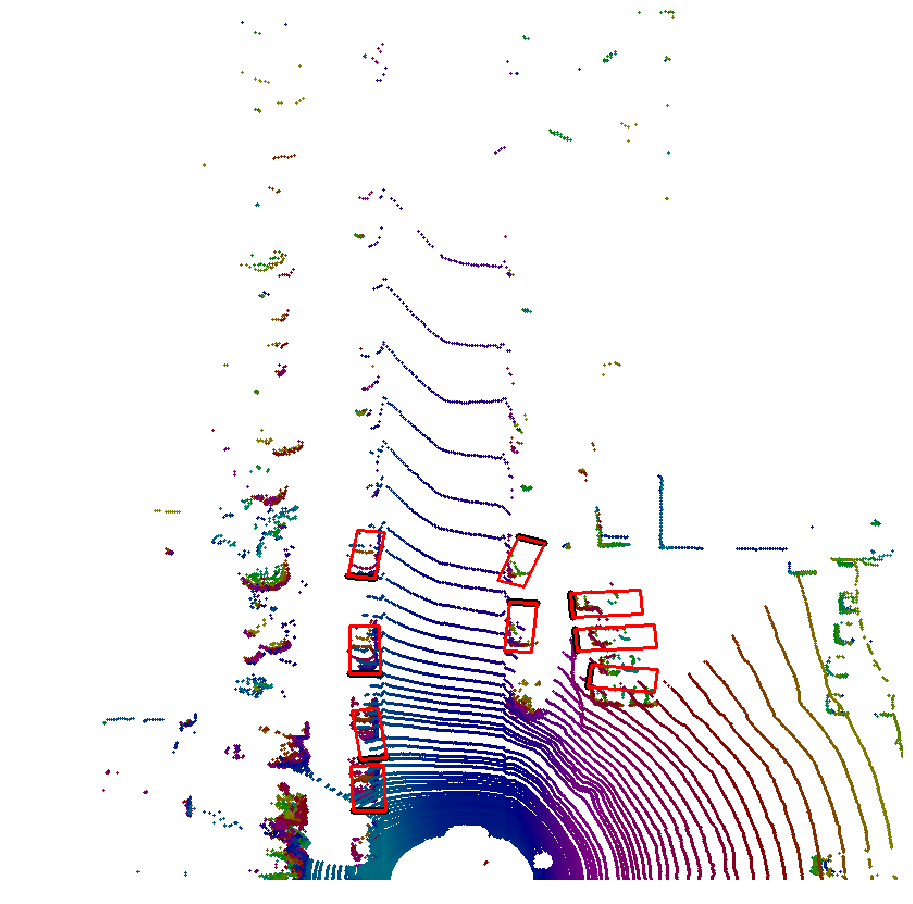

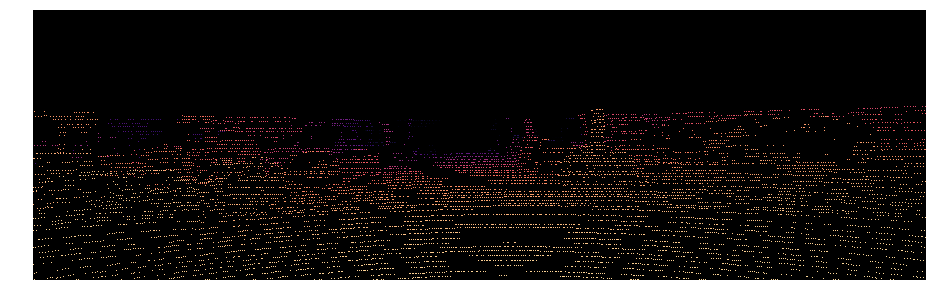

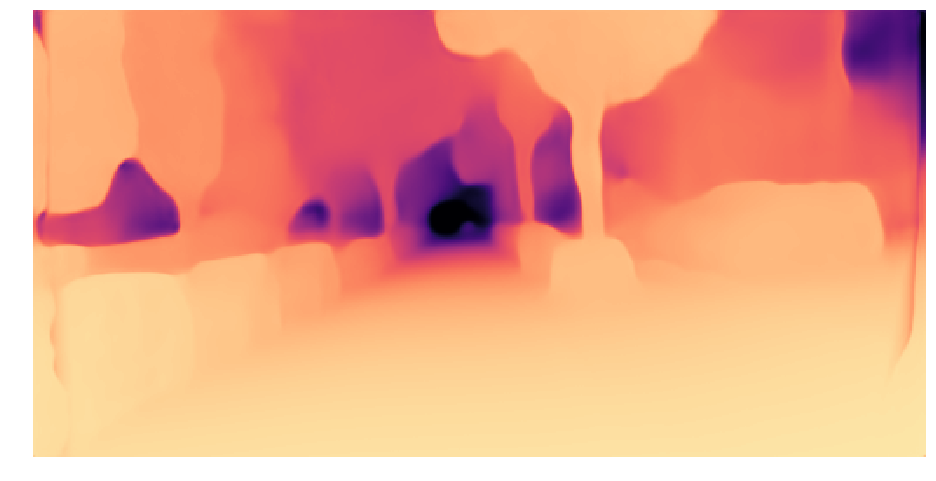

In [9]:
import matplotlib.pyplot as plt

# camera intrinsic matrix
K = np.array([[7.215377000000e+02, 0.000000000000e+00, 6.095593000000e+02, 4.485728000000e+01],
              [0.000000000000e+00, 7.215377000000e+02, 1.728540000000e+02, 2.163791000000e-01],
              [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 2.745884000000e-03]])

# lidar-to-camera extrinsics
T_lidar2cam = np.array([[ 0.0002, -0.9999, -0.0106,  0.0594],
                        [ 0.0104,  0.0106, -0.9999, -0.0751],
                        [ 0.9999,  0.0001,  0.0105, -0.2721],
                        [ 0.,      0.,      0.,      1.    ]])

# left
plt.figure(figsize=(16,16))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# right
plt.figure(figsize=(16,16))
plt.imshow(img_right_rgb)
plt.axis('off')
plt.show()

pc_img = draw_point_cloud_topdown(velo_pc, canvasSize=800, \
                                        xlim=trainer.xlim, ylim=trainer.ylim, zlim=trainer.zlim)
pc_img = np.array( pc_img*255.0, dtype=np.uint8)

plt.figure(figsize=(16,16))
plt.imshow(pc_img)
plt.axis('off')
plt.show()

# predicted bbox
pc_bbox_img = draw_point_cloud_w_bbox(velo_pc, label_dict, canvasSize=800, \
                                        xlim=trainer.xlim, ylim=trainer.ylim, zlim=trainer.zlim)
pc_bbox_img = np.array(pc_bbox_img*255.0, dtype=np.uint8)

plt.figure(figsize=(16,16))
plt.imshow(pc_bbox_img)
plt.axis('off')
plt.show()

# reprojection
projected_img = project_pc2image(velo_pc, T_lidar2cam, K, (img_rgb.shape[1], img_rgb.shape[0]))
projected_img_colorized = colorize_depth_map(projected_img, 0., 70.0, mask_zeros=True)
projected_img_colorized = np.array(projected_img_colorized, dtype=np.uint8)
plt.figure(figsize=(16,16))
plt.imshow(projected_img_colorized)
plt.axis('off')
plt.show()
    
# depth
dense_depth_colorized = colorize_depth_map(dense_depth)
dense_depth_colorized = np.array(dense_depth_colorized, dtype=np.uint8)
plt.figure(figsize=(16,16))
plt.imshow(dense_depth_colorized)
plt.axis('off')
plt.show()